In [ ]:
import numpy as np
import pandas as pd
import time
import keras
import re
import matplotlib.pyplot as plt
%matplotlib inline

import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics  import classification_report
from sklearn import metrics
from sklearn.externals import joblib

import time
from google.colab import drive
from google.colab import files
import warnings
warnings.filterwarnings("ignore")
drive.mount("/content/gdrive")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/dataset1.csv')
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
df

,ArticleId,Text,Category
0,10306,Advocates say murderers with mental disorders ...,politics
1,4384,With much of the developed world hobbling unde...,business
2,320,Issei Kato / Reuters Roger Federer cries as he...,sport
3,4255,The host surprised a Hollywood tour bus group ...,entertainment
4,3649,"Taken at face value, a rare acknowledgment by ...",sport
...,...,...,...
47756,7049,"Well, that was quick!\n\nA little over a week ...",entertainment
47757,13272,At his turbulent his news event last Wednesday...,politics
47758,6939,"In a galaxy far, far away, Jennifer Lawrence a...",entertainment
47759,9271,"Fox News and its Washington, D.C., affiliate, ...",politics


In [ ]:
# Eliminating the null values in the dataset
df.drop(df[pd.isnull(df.Category)].index, inplace=True)
df.drop(df[pd.isnull(df.Text)].index, inplace=True)
df.drop(df[pd.isnull(df.ArticleId)].index, inplace=True)
df

,ArticleId,Text,Category
0,10306,Advocates say murderers with mental disorders ...,politics
1,4384,With much of the developed world hobbling unde...,business
2,320,Issei Kato / Reuters Roger Federer cries as he...,sport
3,4255,The host surprised a Hollywood tour bus group ...,entertainment
4,3649,"Taken at face value, a rare acknowledgment by ...",sport
...,...,...,...
47756,7049,"Well, that was quick!\n\nA little over a week ...",entertainment
47757,13272,At his turbulent his news event last Wednesday...,politics
47758,6939,"In a galaxy far, far away, Jennifer Lawrence a...",entertainment
47759,9271,"Fox News and its Washington, D.C., affiliate, ...",politics


In [ ]:
df['category_id'] = df['Category'].factorize()[0]
df['category_id'][0:10]
df.head()

,ArticleId,Text,Category,category_id
0,10306,Advocates say murderers with mental disorders ...,politics,0
1,4384,With much of the developed world hobbling unde...,business,1
2,320,Issei Kato / Reuters Roger Federer cries as he...,sport,2
3,4255,The host surprised a Hollywood tour bus group ...,entertainment,3
4,3649,"Taken at face value, a rare acknowledgment by ...",sport,2


In [ ]:
# Listing the Categories
categories = list(df['Category'].unique())
categories

['politics', 'business', 'sport', 'entertainment', 'tech']

In [ ]:
df.groupby('Category').category_id.count()

Category
business          5359
entertainment    15628
politics         19851
sport             4834
tech              2041
Name: category_id, dtype: int64

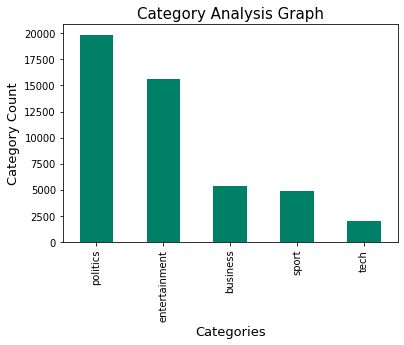

In [ ]:
df['Category'].value_counts().plot(kind='bar', colormap = "summer")
plt.title("Category Analysis Graph", fontsize=15)
plt.xlabel("Categories", fontsize=13)
plt.ylabel("Category Count", fontsize=13)
plt.show()

In [ ]:
# Cleaning the Data
def clean_data(text):
   # Normalizing the text
  try:
    cleaned_text = re.sub(r"[^a-zA-Z]", " ", str(text).lower())
  except:
    cleaned_text = str(text).lower()
  tokens = word_tokenize(cleaned_text)  # Tockenizing the text
  stop_words = stopwords.words("english") 
  token_words = [t for t in tokens if t not in stop_words]  # Removing the stopwords from the text
  final_text = [WordNetLemmatizer().lemmatize(w) for w in token_words]  # Converting words in their base form via lammitization
  return final_text

In [ ]:
df['cleaned_text'] = df['Text'].apply(lambda x: clean_data(x))
df

,ArticleId,Text,Category,category_id,cleaned_text
0,10306,Advocates say murderers with mental disorders ...,politics,0,"[advocate, say, murderer, mental, disorder, li..."
1,4384,With much of the developed world hobbling unde...,business,1,"[much, developed, world, hobbling, burden, mas..."
2,320,Issei Kato / Reuters Roger Federer cries as he...,sport,2,"[issei, kato, reuters, roger, federer, cry, ho..."
3,4255,The host surprised a Hollywood tour bus group ...,entertainment,3,"[host, surprised, hollywood, tour, bus, group,..."
4,3649,"Taken at face value, a rare acknowledgment by ...",sport,2,"[taken, face, value, rare, acknowledgment, int..."
...,...,...,...,...,...
47756,7049,"Well, that was quick!\n\nA little over a week ...",entertainment,3,"[well, quick, little, week, kylie, jenner, tyg..."
47757,13272,At his turbulent his news event last Wednesday...,politics,0,"[turbulent, news, event, last, wednesday, dign..."
47758,6939,"In a galaxy far, far away, Jennifer Lawrence a...",entertainment,3,"[galaxy, far, far, away, jennifer, lawrence, a..."
47759,9271,"Fox News and its Washington, D.C., affiliate, ...",politics,0,"[fox, news, washington, c, affiliate, fox, sta..."


In [ ]:
# Checking the most occuring Unigrams in every category of the text
print("Most Common Words in Every Category")
for c in categories:
  print("Category : ", c)
  catdf = df[df["Category"]==c]
  words = [word for tokens in catdf["cleaned_text"] for word in tokens]
  words_count = Counter(words)
  print(words_count.most_common(10))
  print()

Most Common Words in Every Category
Category :  politics
[('trump', 119544), ('said', 75338), ('president', 46102), ('state', 46073), ('would', 45956), ('u', 39847), ('people', 38262), ('one', 33447), ('republican', 33365), ('year', 33324)]

Category :  business
[('company', 13163), ('year', 11296), ('said', 11185), ('people', 10325), ('time', 10224), ('one', 10010), ('business', 9428), ('new', 9099), ('u', 8033), ('work', 7813)]

Category :  sport
[('game', 9301), ('team', 6762), ('said', 6607), ('year', 6463), ('one', 5519), ('player', 5347), ('time', 4959), ('first', 4507), ('sport', 3900), ('two', 3540)]

Category :  entertainment
[('like', 19595), ('one', 18757), ('year', 16795), ('said', 16372), ('show', 15703), ('film', 15700), ('time', 15113), ('new', 13367), ('people', 12063), ('also', 11854)]

Category :  tech
[('said', 4915), ('company', 3305), ('new', 3175), ('people', 2956), ('apple', 2729), ('one', 2703), ('year', 2482), ('like', 2360), ('time', 2131), ('would', 2105)]



In [ ]:
# Joining the cleaned words to generate Pre-processed text
df['final_cleaned_text'] = df['cleaned_text'].apply(' '.join)
df.head()

,ArticleId,Text,Category,category_id,cleaned_text,final_cleaned_text
0,10306,Advocates say murderers with mental disorders ...,politics,0,"[advocate, say, murderer, mental, disorder, li...",advocate say murderer mental disorder like sch...
1,4384,With much of the developed world hobbling unde...,business,1,"[much, developed, world, hobbling, burden, mas...",much developed world hobbling burden massive p...
2,320,Issei Kato / Reuters Roger Federer cries as he...,sport,2,"[issei, kato, reuters, roger, federer, cry, ho...",issei kato reuters roger federer cry hold trop...
3,4255,The host surprised a Hollywood tour bus group ...,entertainment,3,"[host, surprised, hollywood, tour, bus, group,...",host surprised hollywood tour bus group direct...
4,3649,"Taken at face value, a rare acknowledgment by ...",sport,2,"[taken, face, value, rare, acknowledgment, int...",taken face value rare acknowledgment internati...


In [ ]:
# Splitting the dataset in train and test sets
X = df['final_cleaned_text']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Using TF-IDF to identify the feature vectors inside text
tf_vec = TfidfVectorizer()
train_features = tf_vec.fit_transform(X_train)
test_features = tf_vec.transform(X_test)
print(train_features.shape)

(38170, 135972)


In [ ]:
# Fitting the model on our splitted features from above
SVC = svm.SVC()
SVC.fit(train_features,y_train)
train_predicted = SVC.predict(train_features)
test_predicted = SVC.predict(test_features)

In [ ]:
# Evaluating the Model
from sklearn.metrics  import classification_report
results ={}
results['classification_report'] = classification_report(y_test, test_predicted)
print("Model : SVC")
for i in results:
  print(results[i])

Model : SVC
               precision    recall  f1-score   support

     business       0.87      0.81      0.84      1102
entertainment       0.92      0.96      0.94      3115
     politics       0.94      0.95      0.95      3957
        sport       0.92      0.88      0.90       961
         tech       0.82      0.71      0.76       408

     accuracy                           0.92      9543
    macro avg       0.90      0.86      0.88      9543
 weighted avg       0.92      0.92      0.92      9543



In [ ]:
# Saving the model
joblib_file = "joblib_model.sav"
joblib.dump(SVC, joblib_file)

['joblib_model.sav']

In [ ]:
# Load from file
joblib_model = joblib.load(joblib_file)

In [ ]:
# Gathering and Preparing data for classification
def gather_text(filename):
  with open(filename, 'r') as f:
    text_data = f.read().replace('\n', ' ')
    index = text_data.find('Article:')
    text_data = text_data[index:]
    text_data = text_data.replace("Article:","",1)
    f.close()
    return text_data
text_data = gather_text('/content/gdrive/My Drive/ab.txt')
print(text_data)

Abid Ali was in scintillating form again on day two of the second Test against Zimbabwe but is unlikely to be required to bat again.Pakistan strengthened their grip on the second Test against Zimbabwe in Harare after an unbeaten 215 from Abid Ali allowed the tourists to declare on 510-8. And Zimbabwe were quickly reduced to 52-4in reply by the end of day two as Pakistan closed on a dominant sweep of the two-match series.The touring side, who won the opener by an innings and 116 runs, resumed on 268-4 on Saturday and could not be slowed.It took Zimbabwe 54 balls to remove nightwatchman Sajid Khan (20), installed alongside Abid after a belated flurry of wickets on Friday, although Abid's scoring was only steady as Mohammad Rizwan and Hasan Ali also departed.The arrival of Nauman Ali at the crease prompted a huge partnership of 169 and the duo looked immovable at the close of the second session.Nauman was just seven shy of a maiden century, having been out for a duck in the previous match

In [ ]:
# Passing the data to the loaded model for prediction
def classify_articles(article):
  fin_text = clean_data(article)
  data = ' '.join(fin_text)
  final_text = tf_vec.transform([data])
  predict = joblib_model.predict(final_text)
  pred_category = predict[0]
  return pred_category
print("Article's Category is :",classify_articles(text_data))

Article's Category is : sport
